In [1]:
import torch
from torch.utils.data import Dataset
from torch import nn
import torchvision.transforms.functional as FT
import torch.backends.cudnn as cudnn
import torchvision

import os
from PIL import Image, ImageDraw, ImageFont
import json
import random
import time
import math
import warnings
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


warnings.filterwarnings("ignore")


In [ ]:
#This code snippet configures the device and sets up parameters for training a GAN for image super-resolution, including paths to data, model architecture details, training hyperparameters, and normalization constants. It also enables CUDA performance optimization with cudnn.benchmark = True.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Data parameters
data_folder = '/Users/duerk/Downloads/DIV2K_train_LR_bicubic/train/'  # folder with JSON data files
crop_size = 96  # crop size of target HR images
scaling_factor = 4  # the scaling factor for the generator; the input LR images will be downsampled from the target HR images by this factor

# Model parameters
large_kernel_size = 9  # kernel size of the first and last convolutions which transform the inputs and outputs
small_kernel_size = 3  # kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
n_channels = 64  # number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
n_blocks = 16  # number of residual blocks

# Generator parameters
large_kernel_size_g = 9  # kernel size of the first and last convolutions which transform the inputs and outputs
small_kernel_size_g = 3  # kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
n_channels_g = 64  # number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
n_blocks_g = 16  # number of residual blocks
srresnet_checkpoint = "./checkpoint_srresnet.pth.tar"  # filepath of the trained SRResNet checkpoint used for initialization

# Some constants
rgb_weights = torch.FloatTensor([65.481, 128.553, 24.966]).to(device)
imagenet_mean = torch.FloatTensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(2)
imagenet_std = torch.FloatTensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(2)
imagenet_mean_cuda = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)
imagenet_std_cuda = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)

# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = 16  # batch size
start_epoch = 0  # start at this epoch
iterations = 1e6  # number of training iterations
workers = 4  # number of workers for loading data in the DataLoader
print_freq = 500  # print training status once every __ batches
lr = 1e-4  # learning rate
grad_clip = None  # clip if gradients are exploding


cudnn.benchmark = True

In [ ]:
#Sets parameters for the generator and discriminator of a GAN, including paths to checkpoints and architecture specifics. Also configures learning parameters such as loss indices for VGG-based perceptual loss and the frequency of training status updates.

In [3]:

# Generator parameters
srresnet_checkpoint = "./checkpoint_srresnet.pth.tar"  # filepath of the trained SRResNet checkpoint used for initialization

# Discriminator parameters
kernel_size_d = 3  # kernel size in all convolutional blocks
n_channels_d = 64  # number of output channels in the first convolutional block, after which it is doubled in every 2nd block thereafter
n_blocks_d = 8  # number of convolutional blocks
fc_size_d = 1024  # size of the first fully connected layer

# Learning parameters
checkpoint = None  # path to model (SRGAN) checkpoint, None if none
#number_of_iterations = 2e5  # number of training number_of_iterations
vgg19_i = 5  # the index i in the definition for VGG loss; see paper or models.py
vgg19_j = 4  # the index j in the definition for VGG loss; see paper or models.py
beta = 1e-3  # the coefficient to weight the adversarial loss in the perceptual loss
print_freq = 500  # print training status once every __ batches


In [ ]:
#generates and saves lists of image file paths that meet a specified size criteria for both training and multiple test datasets. It filters images by a minimum width and height threshold, groups training images from multiple directories into one list, and separates test images into lists for each specified test directory. The resulting lists are then saved as JSON files at the specified output location.

In [4]:

def create_data_lists(train_folder_list, test_folder_list, size_threshold, output_location):
    """
    Create lists for images in the training set and each of the test sets.

    :param train_folder_list: folders containing the training images; these will be merged
    :param test_folder_list: folders containing the test images; each test folder will form its own test set
    :param size_threshold: minimum width and height of images to be considered
    :param output_location: save data lists here
    """
    print("\nCreating data lists... this may take some time.\n")
    train_images = list()
    for d in train_folder_list:
        for i in os.listdir(d):
            img_path = os.path.join(d, i)
            original_image = Image.open(img_path, mode='r')
            if original_image.width >= size_threshold and original_image.height >= size_threshold:
                train_images.append(img_path)
    print("There are %d images in the training data.\n" % len(train_images))
    with open(os.path.join(output_location, 'train_images.json'), 'w') as j:
        json.dump(train_images, j)

    for d in test_folder_list:
        test_images = list()
        test_name = d.split_proper("/")[-1]
        for i in os.listdir(d):
            img_path = os.path.join(d, i)
            original_image = Image.open(img_path, mode='r')
            if original_image.width >= size_threshold and original_image.height >= size_threshold:
                test_images.append(img_path)
        print("There are %d images in the %s test data.\n" % (len(test_images), test_name))
        with open(os.path.join(output_location, test_name + '_test_images.json'), 'w') as j:
            json.dump(test_images, j)

    print("JSONS containing lists of Train and Test images have been saved to %s\n" % output_location)

In [ ]:
#converts an image between various formats, including different pixel value ranges and specific preprocessing requirements such as ImageNet normalization or extracting the luminance channel. It ensures the input format is supported, adjusts pixel values as necessary, and handles both individual images and batched images in tensor format. The function also includes conditions for handling different image dimensions and applies specific transformations to achieve the desired output format.

In [5]:

def convert_image(original_image, source_image, target_image):
    """
    Convert an image from a source_image format to a target_image format.

    :param original_image: image
    :param source_image: source_image format, one of 'pil' (PIL image), '[0, 1]' or '[-1, 1]' (pixel value ranges)
    :param target_image: target_image format, one of 'pil' (PIL image), '[0, 255]', '[0, 1]', '[-1, 1]' (pixel value ranges),
                   'imagenet-norm' (pixel values standardized by imagenet mean and std.),
                   'y-channel' (luminance channel Y in the YCbCr color format, used to calculate PSNR and SSIM)
    :return: converted image
    """
    assert source_image in {'pil', '[0, 1]', '[-1, 1]'}, "Cannot convert from source_image format %s!" % source_image
    assert target_image in {'pil', '[0, 255]', '[0, 1]', '[-1, 1]', 'imagenet-norm',
                      'y-channel'}, "Cannot convert to target_image format %s!" % target_image

    # Convert from source_image to [0, 1]
    if source_image == 'pil':
        original_image = FT.to_tensor(original_image)

    elif source_image == '[0, 1]':
        pass  # already in [0, 1]

    elif source_image == '[-1, 1]':
        original_image = (original_image + 1.) / 2.

    # Convert from [0, 1] to target_image
    if target_image == 'pil':
        original_image = FT.to_pil_image(original_image)

    elif target_image == '[0, 255]':
        original_image = 255. * original_image

    elif target_image == '[0, 1]':
        pass  # already in [0, 1]

    elif target_image == '[-1, 1]':
        original_image = 2. * original_image - 1.

    elif target_image == 'imagenet-norm':
        if original_image.ndimension() == 3:
            original_image = (original_image - mean_of_image) / std_of_image
        elif original_image.ndimension() == 4:
            original_image = (original_image - mean_of_image_cuda) / std_of_image_cuda

    elif target_image == 'y-channel':
        # Based on definitions at https://github.com/xinntao/BasicSR/wiki/Color-conversion-in-SR
        # torch.dot() does not work the same way as numpy.dot()
        # So, use torch.matmul() to find the dot product between the last dimension of an 4-D tensor and a 1-D tensor
        original_image = torch.matmul(255. * original_image.permute(0, 2, 3, 1)[:, 4:-4, 4:-4, :], image_weights_proper) / 255. + 16.

    return original_image

In [ ]:
#This segment defines utilities for image processing and training management in a neural network setup. It includes transformations for preparing training and testing datasets, tracking metrics, managing learning rates, and handling model checkpoints and gradient clipping for stability and performance optimization.

In [6]:

class ImageTransformations(object):
    """
    Image transformation pipeline.
    """

    def __init__(self, split_proper, crop_size_in_px, image_scaling_factor, low_res_img_type, high_res_img_type):
        """
        :param split_proper: one of 'train' or 'test'
        :param crop_size_in_px: crop size of HR images
        :param image_scaling_factor: LR images will be downsampled from the HR images by this factor
        :param low_res_img_type: the target_image format for the LR image; see convert_image() above for available formats
        :param high_res_img_type: the target_image format for the HR image; see convert_image() above for available formats
        """
        self.split_proper = split_proper.lower()
        self.crop_size_in_px = crop_size_in_px
        self.image_scaling_factor = image_scaling_factor
        self.low_res_img_type = low_res_img_type
        self.high_res_img_type = high_res_img_type

        assert self.split_proper in {'train', 'test'}

    def __call__(self, original_image):
        """
        :param original_image: a PIL source_image image from which the HR image will be cropped, and then downsampled to create the LR image
        :return: LR and HR images in the specified format
        """

        # Crop
        if self.split_proper == 'train':
            # Take a random fixed-size crop of the image, which will serve as the high-resolution (HR) image
            left = random.randint(1, original_image.width - self.crop_size_in_px)
            top = random.randint(1, original_image.height - self.crop_size_in_px)
            right = left + self.crop_size_in_px
            bottom = top + self.crop_size_in_px
            high_res_image = original_image.crop((left, top, right, bottom))
        else:
            # Take the largest possible center-crop of it such that its dimensions are perfectly divisible by the scaling factor
            x_remainder = original_image.width % self.image_scaling_factor
            y_remainder = original_image.height % self.image_scaling_factor
            left = x_remainder // 2
            top = y_remainder // 2
            right = left + (original_image.width - x_remainder)
            bottom = top + (original_image.height - y_remainder)
            high_res_image = original_image.crop((left, top, right, bottom))

        # Downsize this crop to obtain a low-resolution version of it
        low_res_image = high_res_image.resize((int(high_res_image.width / self.image_scaling_factor), int(high_res_image.height / self.image_scaling_factor)),
                               Image.BICUBIC)

        # Sanity check
        assert high_res_image.width == low_res_image.width * self.image_scaling_factor and high_res_image.height == low_res_image.height * self.image_scaling_factor

        # Convert the LR and HR image to the required type
        low_res_image = convert_image(low_res_image, source_image='pil', target_image=self.low_res_img_type)
        high_res_image = convert_image(high_res_image, source_image='pil', target_image=self.high_res_img_type)

        return low_res_image, high_res_image


class AvgMetrics(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.

    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


def save_checkpoint(state, filename):
    """
    Save model checkpoint_proper.

    :param state: checkpoint_proper contents
    """

    torch.save(state, filename)


def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.

    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))

In [ ]:
#
This segment defines classes for convolutional, subpixel convolutional, and residual blocks, as well as complete network architectures for SRResNet and SRGAN generator and discriminator models. These models are used for upscaling low-resolution images to high-resolution outputs, managing model training, and evaluating with a discriminator or using a truncated VGG19 for feature-based loss calculation.

In [7]:

class ConvolutionalBlock(nn.Module):
    """
    A convolutional block, comprising convolutional, BN, activation layers.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, batch_norm=False, activation=None):
        """
        :param in_channels: number of input channels
        :param out_channels: number of output channe;s
        :param kernel_size: kernel size
        :param stride: stride
        :param batch_norm: include a BN layer?
        :param activation: Type of activation; None if none
        """
        super(ConvolutionalBlock, self).__init__()

        if activation is not None:
            activation = activation.lower()
            assert activation in {'prelu', 'leakyrelu', 'tanh'}

        # A container that will hold the layers in this convolutional block
        layers = list()

        # A convolutional layer
        layers.append(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2))

        # A batch normalization (BN) layer, if wanted
        if batch_norm is True:
            layers.append(nn.BatchNorm2d(num_features=out_channels))

        # An activation layer, if wanted
        if activation == 'prelu':
            layers.append(nn.PReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU(0.2))
        elif activation == 'tanh':
            layers.append(nn.Tanh())

        # Put together the convolutional block as a sequence of the layers in this container
        self.conv_block = nn.Sequential(*layers)

    def forward(self, input):
        """
        Forward propagation.

        :param input: input images, a tensor of size (N, in_channels, w, h)
        :return: output images, a tensor of size (N, out_channels, w, h)
        """
        output = self.conv_block(input)  # (N, out_channels, w, h)

        return output


class SubPixelConvolutionalBlock(nn.Module):
    """
    A subpixel convolutional block, comprising convolutional, pixel-shuffle, and PReLU activation layers.
    """

    def __init__(self, kernel_size=3, n_channels=64, scaling_factor=2):
        """
        :param kernel_size: kernel size of the convolution
        :param n_channels: number of input and output channels
        :param scaling_factor: factor to scale input images by (along both dimensions)
        """
        super(SubPixelConvolutionalBlock, self).__init__()

        # A convolutional layer that increases the number of channels by scaling factor^2, followed by pixel shuffle and PReLU
        self.conv = nn.Conv2d(in_channels=n_channels, out_channels=n_channels * (scaling_factor ** 2),
                              kernel_size=kernel_size, padding=kernel_size // 2)
        # These additional channels are shuffled to form additional pixels, upscaling each dimension by the scaling factor
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=scaling_factor)
        self.prelu = nn.PReLU()

    def forward(self, input):
        """
        Forward propagation.

        :param input: input images, a tensor of size (N, n_channels, w, h)
        :return: scaled output images, a tensor of size (N, n_channels, w * scaling factor, h * scaling factor)
        """
        output = self.conv(input)  # (N, n_channels * scaling factor^2, w, h)
        output = self.pixel_shuffle(output)  # (N, n_channels, w * scaling factor, h * scaling factor)
        output = self.prelu(output)  # (N, n_channels, w * scaling factor, h * scaling factor)

        return output


class ResidualBlock(nn.Module):
    """
    A residual block, comprising two convolutional blocks with a residual connection across them.
    """

    def __init__(self, kernel_size=3, n_channels=64):
        """
        :param kernel_size: kernel size
        :param n_channels: number of input and output channels (same because the input must be added to the output)
        """
        super(ResidualBlock, self).__init__()

        # The first convolutional block
        self.conv_block1 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=True, activation='PReLu')

        # The second convolutional block
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=True, activation=None)

    def forward(self, input):
        """
        Forward propagation.

        :param input: input images, a tensor of size (N, n_channels, w, h)
        :return: output images, a tensor of size (N, n_channels, w, h)
        """
        residual = input  # (N, n_channels, w, h)
        output = self.conv_block1(input)  # (N, n_channels, w, h)
        output = self.conv_block2(output)  # (N, n_channels, w, h)
        output = output + residual  # (N, n_channels, w, h)

        return output


class SRResNet(nn.Module):
    """
    The SRResNet, as defined in the paper.
    """

    def __init__(self, large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=4):
        """
        :param large_kernel_size: kernel size of the first and last convolutions which transform the inputs and outputs
        :param small_kernel_size: kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
        :param n_channels: number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
        :param n_blocks: number of residual blocks
        :param scaling_factor: factor to scale input images by (along both dimensions) in the subpixel convolutional block
        """
        super(SRResNet, self).__init__()

        # Scaling factor must be 2, 4, or 8
        scaling_factor = int(scaling_factor)
        assert scaling_factor in {2, 4, 8}, "The scaling factor must be 2, 4, or 8!"

        # The first convolutional block
        self.conv_block1 = ConvolutionalBlock(in_channels=3, out_channels=n_channels, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='PReLu')

        # A sequence of n_blocks residual blocks, each containing a skip-connection across the block
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(kernel_size=small_kernel_size, n_channels=n_channels) for i in range(n_blocks)])

        # Another convolutional block
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels,
                                              kernel_size=small_kernel_size,
                                              batch_norm=True, activation=None)

        # Upscaling is done by sub-pixel convolution, with each such block upscaling by a factor of 2
        n_subpixel_convolution_blocks = int(math.log2(scaling_factor))
        self.subpixel_convolutional_blocks = nn.Sequential(
            *[SubPixelConvolutionalBlock(kernel_size=small_kernel_size, n_channels=n_channels, scaling_factor=2) for i
              in range(n_subpixel_convolution_blocks)])

        # The last convolutional block
        self.conv_block3 = ConvolutionalBlock(in_channels=n_channels, out_channels=3, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='Tanh')

    def forward(self, lr_imgs):
        """
        Forward prop.

        :param lr_imgs: low-resolution input images, a tensor of size (N, 3, w, h)
        :return: super-resolution output images, a tensor of size (N, 3, w * scaling factor, h * scaling factor)
        """
        output = self.conv_block1(lr_imgs)  # (N, 3, w, h)
        residual = output  # (N, n_channels, w, h)
        output = self.residual_blocks(output)  # (N, n_channels, w, h)
        output = self.conv_block2(output)  # (N, n_channels, w, h)
        output = output + residual  # (N, n_channels, w, h)
        output = self.subpixel_convolutional_blocks(output)  # (N, n_channels, w * scaling factor, h * scaling factor)
        sr_imgs = self.conv_block3(output)  # (N, 3, w * scaling factor, h * scaling factor)

        return sr_imgs


class Generator(nn.Module):
    """
    The generator in the SRGAN, as defined in the paper. Architecture identical to the SRResNet.
    """

    def __init__(self, large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=4):
        """
        :param large_kernel_size: kernel size of the first and last convolutions which transform the inputs and outputs
        :param small_kernel_size: kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
        :param n_channels: number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
        :param n_blocks: number of residual blocks
        :param scaling_factor: factor to scale input images by (along both dimensions) in the subpixel convolutional block
        """
        super(Generator, self).__init__()

        # The generator is simply an SRResNet, as above
        self.net = SRResNet(large_kernel_size=large_kernel_size, small_kernel_size=small_kernel_size,
                            n_channels=n_channels, n_blocks=n_blocks, scaling_factor=scaling_factor)

    def initialize_with_srresnet(self, srresnet_checkpoint):
        """
        Initialize with weights from a trained SRResNet.

        :param srresnet_checkpoint: checkpoint filepath
        """
        srresnet = torch.load(srresnet_checkpoint)['model']
        self.net.load_state_dict(srresnet.state_dict())

        print("\nLoaded weights from pre-trained SRResNet.\n")

    def forward(self, lr_imgs):
        """
        Forward prop.

        :param lr_imgs: low-resolution input images, a tensor of size (N, 3, w, h)
        :return: super-resolution output images, a tensor of size (N, 3, w * scaling factor, h * scaling factor)
        """
        sr_imgs = self.net(lr_imgs)  # (N, n_channels, w * scaling factor, h * scaling factor)

        return sr_imgs


class Discriminator(nn.Module):
    """
    The discriminator in the SRGAN, as defined in the paper.
    """

    def __init__(self, kernel_size=3, n_channels=64, n_blocks=8, fc_size=1024):
        """
        :param kernel_size: kernel size in all convolutional blocks
        :param n_channels: number of output channels in the first convolutional block, after which it is doubled in every 2nd block thereafter
        :param n_blocks: number of convolutional blocks
        :param fc_size: size of the first fully connected layer
        """
        super(Discriminator, self).__init__()

        in_channels = 3

        # A series of convolutional blocks
        # The first, third, fifth (and so on) convolutional blocks increase the number of channels but retain image size
        # The second, fourth, sixth (and so on) convolutional blocks retain the same number of channels but halve image size
        # The first convolutional block is unique because it does not employ batch normalization
        conv_blocks = list()
        for i in range(n_blocks):
            out_channels = (n_channels if i is 0 else in_channels * 2) if i % 2 is 0 else in_channels
            conv_blocks.append(
                ConvolutionalBlock(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   stride=1 if i % 2 is 0 else 2, batch_norm=i is not 0, activation='LeakyReLu'))
            in_channels = out_channels
        self.conv_blocks = nn.Sequential(*conv_blocks)

        # An adaptive pool layer that resizes it to a standard size
        # For the default input size of 96 and 8 convolutional blocks, this will have no effect
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))

        self.fc1 = nn.Linear(out_channels * 6 * 6, fc_size)

        self.leaky_relu = nn.LeakyReLU(0.2)

        self.fc2 = nn.Linear(1024, 1)

        # Don't need a sigmoid layer because the sigmoid operation is performed by PyTorch's nn.BCEWithLogitsLoss()

    def forward(self, imgs):
        """
        Forward propagation.

        :param imgs: high-resolution or super-resolution images which must be classified as such, a tensor of size (N, 3, w * scaling factor, h * scaling factor)
        :return: a score (logit) for whether it is a high-resolution image, a tensor of size (N)
        """
        batch_size = imgs.size(0)
        output = self.conv_blocks(imgs)
        output = self.adaptive_pool(output)
        output = self.fc1(output.view(batch_size, -1))
        output = self.leaky_relu(output)
        logit = self.fc2(output)

        return logit


class TruncatedVGG19(nn.Module):
    """
    A truncated VGG19 network, such that its output is the 'feature map obtained by the j-th convolution (after activation)
    before the i-th maxpooling layer within the VGG19 network', as defined in the paper.

    Used to calculate the MSE loss in this VGG feature-space, i.e. the VGG loss.
    """

    def __init__(self, i, j):
        """
        :param i: the index i in the definition above
        :param j: the index j in the definition above
        """
        super(TruncatedVGG19, self).__init__()

        # Load the pre-trained VGG19 available in torchvision
        vgg19 = torchvision.models.vgg19(pretrained=True)

        maxpool_counter = 0
        conv_counter = 0
        truncate_at = 0
        # Iterate through the convolutional section ("features") of the VGG19
        for layer in vgg19.features.children():
            truncate_at += 1

            # Count the number of maxpool layers and the convolutional layers after each maxpool
            if isinstance(layer, nn.Conv2d):
                conv_counter += 1
            if isinstance(layer, nn.MaxPool2d):
                maxpool_counter += 1
                conv_counter = 0

            # Break if we reach the jth convolution after the (i - 1)th maxpool
            if maxpool_counter == i - 1 and conv_counter == j:
                break

        # Check if conditions were satisfied
        assert maxpool_counter == i - 1 and conv_counter == j, "One or both of i=%d and j=%d are not valid choices for the VGG19!" % (
            i, j)

        # Truncate to the jth convolution (+ activation) before the ith maxpool layer
        self.truncated_vgg19 = nn.Sequential(*list(vgg19.features.children())[:truncate_at + 1])

    def forward(self, input):
        """
        Forward propagation
        :param input: high-resolution or super-resolution images, a tensor of size (N, 3, w * scaling factor, h * scaling factor)
        :return: the specified VGG19 feature map, a tensor of size (N, feature_map_channels, feature_map_w, feature_map_h)
        """
        output = self.truncated_vgg19(input)  # (N, feature_map_channels, feature_map_w, feature_map_h)

        return output


In [ ]:
# Initializes a custom Dataset for upscaling tasks, managing image files, transformation processes, and data split configurations for training and testing scenarios.

In [8]:

class UpscalerDataset(Dataset):
    """
    A PyTorch Dataset to be used by a PyTorch DataLoader.
    """

    def __init__(self, data_folder, split, crop_size, scaling_factor, lr_img_type, hr_img_type, test_data_name=None):
        """
        :param data_folder: # folder with JSON data files
        :param split: one of 'train' or 'test'
        :param crop_size: crop size of target HR images
        :param scaling_factor: the input LR images will be downsampled from the target HR images by this factor; the scaling done in the super-resolution
        :param lr_img_type: the format for the LR image supplied to the model; see convert_image() in utils.py for available formats
        :param hr_img_type: the format for the HR image supplied to the model; see convert_image() in utils.py for available formats
        :param test_data_name: if this is the 'test' split, which test dataset? (for example, "Set14")
        """

        self.data_folder = data_folder
        self.split = split.lower()
        self.crop_size = int(crop_size)
        self.scaling_factor = int(scaling_factor)
        self.lr_img_type = lr_img_type
        self.hr_img_type = hr_img_type
        self.test_data_name = test_data_name

        assert self.split in {'train', 'test'}
        if self.split == 'test' and self.test_data_name is None:
            raise ValueError("Please provide the name of the test dataset!")
        assert lr_img_type in {'[0, 255]', '[0, 1]', '[-1, 1]', 'imagenet-norm'}
        assert hr_img_type in {'[0, 255]', '[0, 1]', '[-1, 1]', 'imagenet-norm'}

        # If this is a training dataset, then crop dimensions must be perfectly divisible by the scaling factor
        # (If this is a test dataset, images are not cropped to a fixed size, so this variable isn't used)
        if self.split == 'train':
            assert self.crop_size % self.scaling_factor == 0, "Crop dimensions are not perfectly divisible by scaling factor! This will lead to a mismatch in the dimensions of the original HR patches and their super-resolved (SR) versions!"

        # Read list of image-paths
        if self.split == 'train':
            with open(os.path.join(data_folder, 'train_images.json'), 'r') as j:
                self.images = json.load(j)
        else:
            with open(os.path.join(data_folder, self.test_data_name + '_test_images.json'), 'r') as j:
                self.images = json.load(j)

        # Select the correct set of transforms
        self.transform = ImageTransforms(split=self.split,
                                         crop_size=self.crop_size,
                                         scaling_factor=self.scaling_factor,
                                         lr_img_type=self.lr_img_type,
                                         hr_img_type=self.hr_img_type)

    def __getitem__(self, i):
        """
        This method is required to be defined for use in the PyTorch DataLoader.

        :param i: index to retrieve
        :return: the 'i'th pair LR and HR images to be fed into the model
        """
        # Read image
        img = Image.open(self.images[i], mode='r')
        img = img.convert('RGB')
        if img.width <= 96 or img.height <= 96:
            print(self.images[i], img.width, img.height)
        lr_img, hr_img = self.transform(img)

        return lr_img, hr_img

    def __len__(self):
        """
        This method is required to be defined for use in the PyTorch DataLoader.

        :return: size of this data (in number of images)
        """
        return len(self.images)


In [ ]:
# Manages the setup and execution of training cycles for a super-resolution neural network model, including initialization, dataloading, and saving checkpoints.

In [9]:

def srnet_run():
    """
    Training.
    """
    global start_epoch, epoch, checkpoint_proper

    # Initialize model or load checkpoint_proper
    if checkpoint_proper is None:
        model = SRResNet(large_kernel_proper=large_kernel_proper, 
                              small_kernel_proper=small_kernel_proper,
                              number_of_channels=number_of_channels, 
                              number_of_blocks=number_of_blocks, 
                              image_scaling_factor=image_scaling_factor)
        
        # Initialize the optimizer
        optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    else:
        checkpoint_proper = torch.load(checkpoint_proper)
        start_epoch = checkpoint_proper['epoch'] + 1
        model = checkpoint_proper['model']
        optimizer = checkpoint_proper['optimizer']

    # Move to default device
    model = model.to(device)
    criterion = nn.MSELoss().to(device)

    # Custom dataloaders
    train_dataset = SRDataset(folder_containing_data,
                              split_proper='train',
                              crop_size_in_px=crop_size_in_px,
                              image_scaling_factor=image_scaling_factor,
                              low_res_img_type='imagenet-norm',
                              high_res_img_type='[-1, 1]')
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True, 
                                               num_workers=0,
                                               pin_memory=True)  # note that we're passing the collate function here

    # Total number of epochs to train for
    epochs = int(iterations // len(train_loader) + 1)

    # Epochs
    for epoch in range(start_epoch, epochs):
        # One epoch's training
        srnet_train(train_loader=train_loader,
              model=model,
              criterion=criterion,
              optimizer=optimizer,
              epoch=epoch)

        # Save checkpoint_proper
        torch.save({'epoch': epoch,
                    'model': model,
                    'optimizer': optimizer},
                   'checkpoint_srresnet.pth.tar')
        


def srnet_train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: content loss function (Mean Squared-Error loss)
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables batch normalization

    batch_time = AvgMetrics()  # forward prop. + back prop. time
    data_time = AvgMetrics()  # data loading time
    losses = AvgMetrics()  # loss

    start = time.time()

    # Batches
    for i, (lr_imgs, hr_imgs) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        lr_imgs = lr_imgs.to(device)  # (batch_size (N), 3, 24, 24), imagenet-normed
        hr_imgs = hr_imgs.to(device)  # (batch_size (N), 3, 96, 96), in [-1, 1]

        # Forward prop.
        sr_imgs = model(lr_imgs)  # (N, 3, 96, 96), in [-1, 1]

        # Loss
        loss = criterion(sr_imgs, hr_imgs)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        # Keep track of loss
        losses.update(loss.item(), lr_imgs.size(0))

        # Keep track of batch time
        batch_time.update(time.time() - start)

        # Reset start time
        start = time.time()

        # Print status
        if i % update_frequency == 0:
            print('Epoch: [{0}][{1}/{2}]----'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})----'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})----'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, len(train_loader),
                                                                    batch_time=batch_time,
                                                                    data_time=data_time, loss=losses))
    del lr_imgs, hr_imgs, sr_imgs  # free some memory since their histories may be stored


In [ ]:
# Manages the setup and execution of training cycles for a super-resolution GAN (SRGAN), handling model initialization, loss calculation, and optimizer updates.

In [10]:


def srgan_run():
    """
    Training.
    """
    global start_epoch, epoch, checkpoint_proper, res_net_checkpoint_file

    # Initialize model or load checkpoint_proper
    if checkpoint_proper is None:
        # Generator
        generator = Generator(large_kernel_proper=large_kernel_size_proper,
                              small_kernel_proper=small_kernel_size_proper,
                              number_of_channels=number_of_channels_proper,
                              number_of_blocks=number_of_blocks_proper,
                              image_scaling_factor=image_scaling_factor)

        # Initialize generator network with pretrained UpscaleResNet
        generator.init_with_srnet(res_net_checkpoint_file=res_net_checkpoint_file)

        # Initialize generator's optimizer
        optimizer_g = torch.optim.Adam(params=filter(lambda p: p.requires_grad, generator.parameters()),
                                       lr=lr)

        # Discriminator
        discriminator = Discriminator(size_of_kernel=kernel_size_d,
                                      number_of_channels=n_channels_d,
                                      number_of_blocks=n_blocks_d,
                                      fc_size=fc_size_d)

        # Initialize discriminator's optimizer
        optimizer_d = torch.optim.Adam(params=filter(lambda p: p.requires_grad, discriminator.parameters()),
                                       lr=lr)

    else:
        checkpoint_proper = torch.load(checkpoint_proper)
        start_epoch = checkpoint_proper['epoch'] + 1
        generator = checkpoint_proper['generator']
        discriminator = checkpoint_proper['discriminator']
        optimizer_g = checkpoint_proper['optimizer_g']
        optimizer_d = checkpoint_proper['optimizer_d']
        print("\nLoaded checkpoint_proper from epoch %d.\n" % (checkpoint_proper['epoch'] + 1))

    # Truncated VGG19 network to be used in the loss calculation
    truncated_vgg19 = TruncatedVGG19(i=vgg_net_index_1, j=vgg_net_index_22)
    truncated_vgg19.eval()

    # Loss functions
    content_loss_criterion = nn.MSELoss()
    adversarial_loss_criterion = nn.BCEWithLogitsLoss()

    # Move to default device
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    truncated_vgg19 = truncated_vgg19.to(device)
    content_loss_criterion = content_loss_criterion.to(device)
    adversarial_loss_criterion = adversarial_loss_criterion.to(device)

    # Custom dataloaders
    train_dataset = UpscalerDataset(folder_containing_data,
                              split_proper='train',
                              crop_size_in_px=crop_size_in_px,
                              image_scaling_factor=image_scaling_factor,
                              low_res_img_type='imagenet-norm',
                              high_res_img_type='imagenet-norm')
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True, 
                                               num_workers=0,
                                               pin_memory=True)

    # Total number of epochs to train for
    epochs = int(iterations // len(train_loader) + 1)

    # Epochs
    for epoch in range(start_epoch, epochs):

        # At the halfway point, reduce learning rate to a tenth
        if epoch == int((iterations / 2) // len(train_loader) + 1):
            adjust_learning_rate(optimizer_g, 0.1)
            adjust_learning_rate(optimizer_d, 0.1)

        # One epoch's training
        srgan_train(train_loader=train_loader,
              generator=generator,
              discriminator=discriminator,
              truncated_vgg19=truncated_vgg19,
              content_loss_criterion=content_loss_criterion,
              adversarial_loss_criterion=adversarial_loss_criterion,
              optimizer_g=optimizer_g,
              optimizer_d=optimizer_d,
              epoch=epoch)

        # Save checkpoint_proper
        torch.save({'epoch': epoch,
                    'generator': generator,
                    'discriminator': discriminator,
                    'optimizer_g': optimizer_g,
                    'optimizer_d': optimizer_d},
                   'checkpoint_srgan.pth.tar')


def srgan_train(train_loader, generator, discriminator, truncated_vgg19, content_loss_criterion, adversarial_loss_criterion,
          optimizer_g, optimizer_d, epoch):
    """
    One epoch's training.

    :param train_loader: train dataloader
    :param generator: generator
    :param discriminator: discriminator
    :param truncated_vgg19: truncated VGG19 network
    :param content_loss_criterion: content loss function (Mean Squared-Error loss)
    :param adversarial_loss_criterion: adversarial loss function (Binary Cross-Entropy loss)
    :param optimizer_g: optimizer for the generator
    :param optimizer_d: optimizer for the discriminator
    :param epoch: epoch number
    """
    # Set to train mode
    generator.train()
    discriminator.train()  # training mode enables batch normalization

    batch_time = AvgMetrics()  # forward prop. + back prop. time
    data_time = AvgMetrics()  # data loading time
    losses_c = AvgMetrics()  # content loss
    losses_a = AvgMetrics()  # adversarial loss in the generator
    losses_d = AvgMetrics()  # adversarial loss in the discriminator

    start = time.time()

    # Batches
    for i, (lr_imgs, hr_imgs) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        lr_imgs = lr_imgs.to(device)  # (batch_size (N), 3, 24, 24), imagenet-normed
        hr_imgs = hr_imgs.to(device)  # (batch_size (N), 3, 96, 96), imagenet-normed

        # GENERATOR UPDATE

        # Generate
        sr_imgs = generator(lr_imgs)  # (N, 3, 96, 96), in [-1, 1]
        sr_imgs = convert_image(sr_imgs, source_image='[-1, 1]', target_image='imagenet-norm')  # (N, 3, 96, 96), imagenet-normed

        # Calculate VGG feature maps for the super-resolved (SR) and high resolution (HR) images
        sr_imgs_in_vgg_space = truncated_vgg19(sr_imgs)
        hr_imgs_in_vgg_space = truncated_vgg19(hr_imgs).detach()  # detached because they're constant, targets

        # Discriminate super-resolved (SR) images
        sr_discriminated = discriminator(sr_imgs)  # (N)

        # Calculate the Perceptual loss
        content_loss = content_loss_criterion(sr_imgs_in_vgg_space, hr_imgs_in_vgg_space)
        adversarial_loss = adversarial_loss_criterion(sr_discriminated, torch.ones_like(sr_discriminated))
        perceptual_loss = content_loss + weight_coefficient * adversarial_loss

        # Back-prop.
        optimizer_g.zero_grad()
        perceptual_loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer_g, grad_clip)

        # Update generator
        optimizer_g.step()

        # Keep track of loss
        losses_c.update(content_loss.item(), lr_imgs.size(0))
        losses_a.update(adversarial_loss.item(), lr_imgs.size(0))

        # DISCRIMINATOR UPDATE

        # Discriminate super-resolution (SR) and high-resolution (HR) images
        hr_discriminated = discriminator(hr_imgs)
        sr_discriminated = discriminator(sr_imgs.detach())
        # But didn't we already discriminate the SR images earlier, before updating the generator (G)? Why not just use that here?
        # Because, if we used that, we'd be back-propagating (finding gradients) over the G too when backward() is called
        # It's actually faster to detach the SR images from the G and forward-prop again, than to back-prop. over the G unnecessarily
        # See FAQ section in the tutorial

        # Binary Cross-Entropy loss
        adversarial_loss = adversarial_loss_criterion(sr_discriminated, torch.zeros_like(sr_discriminated)) + \
                           adversarial_loss_criterion(hr_discriminated, torch.ones_like(hr_discriminated))

        # Back-prop.
        optimizer_d.zero_grad()
        adversarial_loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer_d, grad_clip)

        # Update discriminator
        optimizer_d.step()

        # Keep track of loss
        losses_d.update(adversarial_loss.item(), hr_imgs.size(0))

        # Keep track of batch times
        batch_time.update(time.time() - start)

        # Reset start time
        start = time.time()

        # Print status
        if i % update_frequency == 0:
            print('Epoch: [{0}][{1}/{2}]----'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})----'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})----'
                  'Cont. Loss {loss_c.val:.4f} ({loss_c.avg:.4f})----'
                  'Adv. Loss {loss_a.val:.4f} ({loss_a.avg:.4f})----'
                  'Disc. Loss {loss_d.val:.4f} ({loss_d.avg:.4f})'.format(epoch,
                                                                          i,
                                                                          len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time,
                                                                          loss_c=losses_c,
                                                                          loss_a=losses_a,
                                                                          loss_d=losses_d))

    del lr_imgs, hr_imgs, sr_imgs, hr_imgs_in_vgg_space, sr_imgs_in_vgg_space, hr_discriminated, sr_discriminated  # free some memory since their histories may be stored


In [ ]:
# Visualizes and compares high-resolution, bicubic-upsampled, and super-resolved images using UpscaleResNet and SRGAN models for quality assessment.

In [11]:

def visualize_sr(original_image, halve=False):
    """
    Visualizes the super-resolved images from the UpscaleResNet and SRGAN for comparison with the bicubic-upsampled image
    and the original high-resolution (HR) image, as done in the paper.

    :param original_image: filepath of the HR iamge
    :param halve: halve each dimension of the HR image to make sure it's not greater than the dimensions of your screen?
                  For instance, for a 2160p HR image, the LR image will be of 540p (1080p/4) resolution. On a 1080p screen,
                  you will therefore be looking at a comparison between a 540p LR image and a 1080p SR/HR image because
                  your 1080p screen can only display the 2160p SR/HR image at a downsampled 1080p. This is only an
                  APPARENT rescaling of 2x.
                  If you want to reduce HR resolution by a different extent, modify accordingly.
    """
    # Load image, downsample to obtain low-res version
    high_res_image = Image.open(original_image, mode="r")
    high_res_image = high_res_image.convert('RGB')
    if halve:
        high_res_image = high_res_image.resize((int(high_res_image.width / 2), int(high_res_image.height / 2)),
                               Image.LANCZOS)
    low_res_image = high_res_image.resize((int(high_res_image.width / 4), int(high_res_image.height / 4)),
                           Image.BICUBIC)

    # Bicubic Upsampling
    bicubic_img = low_res_image.resize((high_res_image.width, high_res_image.height), Image.BICUBIC)

    # Super-resolution (SR) with UpscaleResNet
    sr_img_srresnet = srresnet(convert_image(low_res_image, source_image='pil', target_image='imagenet-norm').unsqueeze(0).to(device))
    sr_img_srresnet = sr_img_srresnet.squeeze(0).cpu().detach()
    sr_img_srresnet = convert_image(sr_img_srresnet, source_image='[-1, 1]', target_image='pil')

    # Super-resolution (SR) with SRGAN
    sr_img_srgan = srgan_generator(convert_image(low_res_image, source_image='pil', target_image='imagenet-norm').unsqueeze(0).to(device))
    sr_img_srgan = sr_img_srgan.squeeze(0).cpu().detach()
    sr_img_srgan = convert_image(sr_img_srgan, source_image='[-1, 1]', target_image='pil')

    # Create grid
    margin = 40
    grid_img = Image.new('RGB', (2 * high_res_image.width + 3 * margin, 2 * high_res_image.height + 3 * margin), (255, 255, 255))

    # Font
    draw = ImageDraw.Draw(grid_img)
    try:
        font = ImageFont.truetype("calibril.ttf", size=23)
        # It will also look for this file in your OS's default fonts directory, where you may have the Calibri Light font installed if you have MS Office
        # Otherwise, use any TTF font of your choice
    except OSError:
        print(
            "Defaulting to a terrible font. To use a font of your choice, include the link to its TTF file in the function.")
        font = ImageFont.load_default()

    # Place bicubic-upsampled image
    grid_img.paste(bicubic_img, (margin, margin))
    text_size = font.getsize("Bicubic")
    draw.text(xy=[margin + bicubic_img.width / 2 - text_size[0] / 2, margin - text_size[1] - 5], text="Bicubic",
              font=font,
              fill='black')

    # Place UpscaleResNet image
    grid_img.paste(sr_img_srresnet, (2 * margin + bicubic_img.width, margin))
    text_size = font.getsize("UpscaleResNet")
    draw.text(
        xy=[2 * margin + bicubic_img.width + sr_img_srresnet.width / 2 - text_size[0] / 2, margin - text_size[1] - 5],
        text="UpscaleResNet", font=font, fill='black')

    # Place SRGAN image
    grid_img.paste(sr_img_srgan, (margin, 2 * margin + sr_img_srresnet.height))
    text_size = font.getsize("SRGAN")
    draw.text(
        xy=[margin + bicubic_img.width / 2 - text_size[0] / 2, 2 * margin + sr_img_srresnet.height - text_size[1] - 5],
        text="SRGAN", font=font, fill='black')

    # Place original HR image
    grid_img.paste(high_res_image, (2 * margin + bicubic_img.width, 2 * margin + sr_img_srresnet.height))
    text_size = font.getsize("Original HR")
    draw.text(xy=[2 * margin + bicubic_img.width + sr_img_srresnet.width / 2 - text_size[0] / 2,
                  2 * margin + sr_img_srresnet.height - text_size[1] - 1], text="Original HR", font=font, fill='black')

    # Display grid
    grid_img.show()

    return grid_img

In [14]:
srnet_run()

Epoch: [0][0/50]----Batch Time 7.557 (7.557)----Data Time 0.152 (0.152)----Loss 0.2713 (0.2713)


KeyboardInterrupt: 

In [13]:
srgan_run()


Loaded weights from pre-trained SRResNet.



KeyboardInterrupt: 

In [ ]:
# Model checkpoints
srgan_checkpoint = "./checkpoint_srgan.pth.tar"
srresnet_checkpoint = "./checkpoint_srresnet.pth.tar"

# Load models
srresnet = torch.load(srresnet_checkpoint)['model'].to(device)
srresnet.eval()
srgan_generator = torch.load(srgan_checkpoint)['generator'].to(device)
srgan_generator.eval()

Generator(
  (net): SRResNet(
    (conv_block1): ConvolutionalBlock(
      (conv_block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (1): PReLU(num_parameters=1)
      )
    )
    (residual_blocks): Sequential(
      (0): ResidualBlock(
        (conv_block1): ConvolutionalBlock(
          (conv_block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): PReLU(num_parameters=1)
          )
        )
        (conv_block2): ConvolutionalBlock(
          (conv_block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
      )
      (1): ResidualBlock(
        (conv_block1): ConvolutionalBlock(
          (conv_block): Seque

In [ ]:
grid_img = visualize_sr("/Users/duerk/Downloads/DIV2K_train_learning_rate_proper_bicubic/train/hr/0001.png")

Defaulting to a terrible font. To use a font of your choice, include the link to its TTF file in the function.


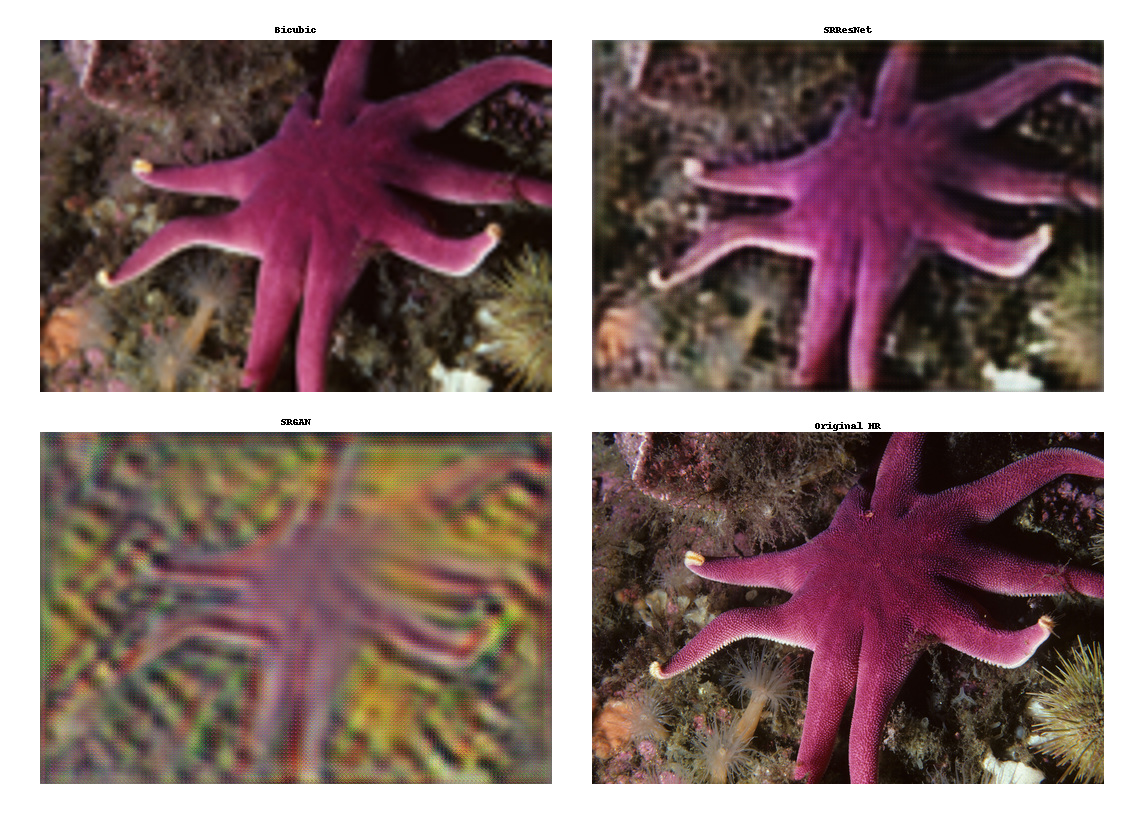

In [ ]:
grid_img

In [ ]:
# Data
folder_containing_data = "/Users/duerk/Downloads/DIV2K_train_learning_rate_proper_bicubic/test"
test_data_names = ["learning_rate_proper"]

In [ ]:
# Loads and evaluates the SRGAN model on a set of test datasets to compute quality metrics like PSNR and SSIM for each test image.

In [ ]:
srgan_generator = torch.load(srgan_checkpoint)['generator'].to(device)
srgan_generator.eval()
model = srgan_generator

# Evaluate
for test_data_name in test_data_names:
    print("\nFor %s:\n" % test_data_name)

    # Custom dataloader
    test_dataset = SRDataset(folder_containing_data,
                             split='test',
                             crop_px=0,
                             scale_by=4,
                             learning_rate_proper_img_type='imagenet-norm',
                             hr_img_type='[-1, 1]',
                             test_data_name=test_data_name)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

    # Keep track of the PSNRs and the SSIMs across batches
    PSNRs = AverageMeter()
    SSIMs = AverageMeter()

    # Prohibit gradient computation explicitly because I had some problems with memory
    with torch.no_grad():
        # Batches
        for i, (learning_rate_proper_imgs, hr_imgs) in enumerate(test_loader):
            # Move to default device
            learning_rate_proper_imgs = learning_rate_proper_imgs.to(device)  # (batch_size (1), 3, w / 4, h / 4), imagenet-normed
            hr_imgs = hr_imgs.to(device)  # (batch_size (1), 3, w, h), in [-1, 1]

            # Forward prop.
            sr_imgs = model(learning_rate_proper_imgs)  # (1, 3, w, h), in [-1, 1]

            # Calculate PSNR and SSIM
            sr_imgs_y = convert_image(sr_imgs, source='[-1, 1]', target='y-channel').squeeze(0)  # (w, h), in y-channel
            hr_imgs_y = convert_image(hr_imgs, source='[-1, 1]', target='y-channel').squeeze(0)  # (w, h), in y-channel
            psnr = peak_signal_noise_ratio(hr_imgs_y.cpu().numpy(), sr_imgs_y.cpu().numpy(),
                                           data_range=255.)
            ssim = structural_similarity(hr_imgs_y.cpu().numpy(), sr_imgs_y.cpu().numpy(),
                                         data_range=255.)
            PSNRs.update(psnr, learning_rate_proper_imgs.size(0))
            SSIMs.update(ssim, learning_rate_proper_imgs.size(0))

    # Print average PSNR and SSIM
    print('PSNR - {psnrs.avg:.3f}'.format(psnrs=PSNRs))
    print('SSIM - {ssims.avg:.3f}'.format(ssims=SSIMs))

print("\n")


For lr:

PSNR - 15.113
SSIM - 0.338


